In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sqlalchemy import create_engine
from monitor import config

%matplotlib inline

In [56]:
engine = create_engine(config.DB_CONFIG)
with engine.connect() as conn, conn.begin():
    query = """
    SELECT
        txs.date, txs.tx_num, blocks.pow_blocks, blocks.pos_blocks,
        txs.tx_num - blocks.pow_blocks - 2*blocks.pos_blocks as payments
    FROM (
        SELECT DISTINCT ON (date)
            date_trunc('day', time) as date,
            SUM(cardinality(tx)) OVER w AS tx_num
        FROM blockchain as bc
        WINDOW w AS (
            PARTITION BY date_trunc('day', time)
        )
    ) txs
    JOIN (
        SELECT
            pow_data.date, pow_data.pow_blocks, pos_data.pos_blocks
        FROM (
            SELECT DISTINCT ON (date)
                date_trunc('day', time) as date,
                COUNT(height) OVER w AS pow_blocks
            FROM (
                SELECT * FROM blockchain WHERE flags ~ 'proof-of-work'
            ) pow
            WINDOW w AS (
                PARTITION BY date_trunc('day', time)
            )
        ) pow_data
        JOIN (
            SELECT DISTINCT ON (date)
                date_trunc('day', time) as date,
                COUNT(height) OVER w AS pos_blocks
            FROM (
                SELECT * FROM blockchain WHERE flags ~ 'proof-of-stake'
            ) pos
            WINDOW w AS (
                PARTITION BY date_trunc('day', time)
            )
        ) pos_data
        ON pow_data.date = pos_data.date
    ) blocks
    ON txs.date = blocks.date
    """
    data = pd.read_sql_query(query, conn)

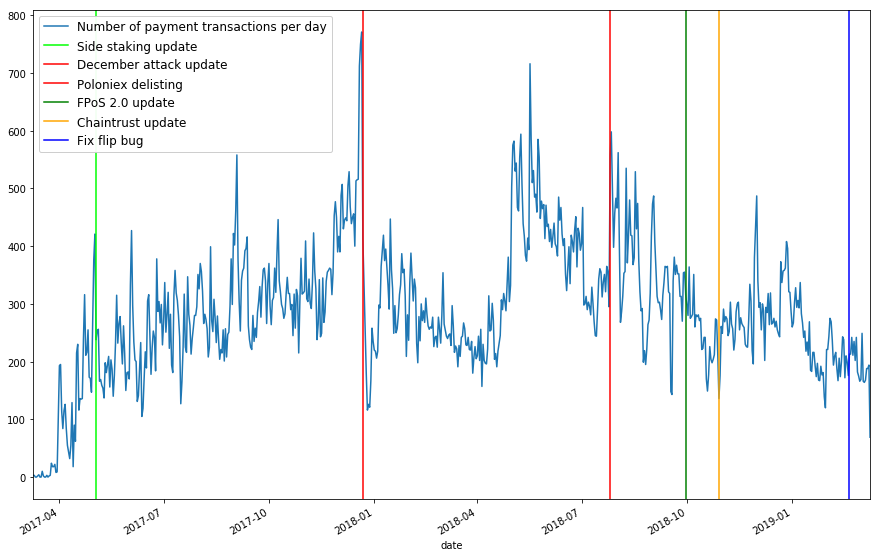

In [63]:
data.plot(
    x="date",
    y="payments",
    figsize=(15, 10),
    label="Number of payment transactions per day"
)

plt.axvline(x=datetime(2017, 5, 3), ymin=0, ymax=2, color="lime", label="Side staking update")
plt.axvline(x=datetime(2017, 12, 22), ymin=0, ymax=2, color="red", label="December attack update")
plt.axvline(x=datetime(2018, 7,26), ymin=0, ymax=2, color="red", label="Poloniex delisting")
plt.axvline(x=datetime(2018, 9, 30), ymin=0, ymax=2, color="green", label="FPoS 2.0 update")
plt.axvline(x=datetime(2018, 10, 29), ymin=0, ymax=2, color="orange", label="Chaintrust update")
plt.axvline(x=datetime(2019, 2, 20), ymin=0, ymax=2, color="blue", label="Fix flip bug");

plt.legend(loc="upper left", framealpha=0.95, prop={"size": 12});

In [15]:
engine = create_engine(config.DB_CONFIG)
with engine.connect() as conn, conn.begin():
    query = """
    SELECT DISTINCT ON (date)
        date_trunc('day', pow.time) as date,
        COUNT(pow.height) OVER w AS common_blocks
    FROM (
        SELECT * FROM blockchain WHERE flags ~ 'proof-of-work'
    ) pow
    JOIN (
        SELECT * FROM blockchain WHERE flags ~ 'proof-of-stake'
    ) pos
    ON pow.time = pos.time
    WINDOW w AS (
        PARTITION BY date_trunc('day', pow.time)
    );
    """
    data = pd.read_sql_query(query, conn)

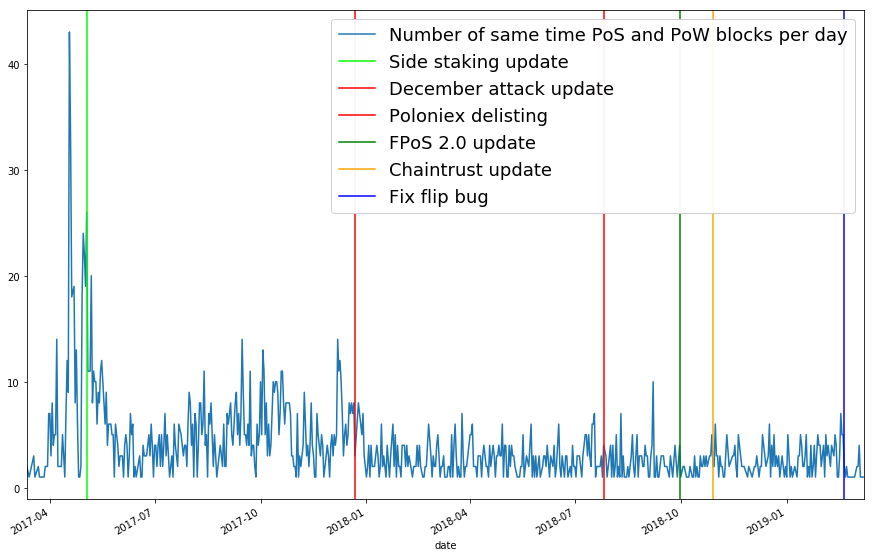

In [18]:
data.plot(
    x="date",
    y="common_blocks",
    figsize=(15, 10),
    label="Number of same time PoS and PoW blocks per day"
)

plt.axvline(x=datetime(2017, 5, 3), ymin=0, ymax=2, color="lime", label="Side staking update")
plt.axvline(x=datetime(2017, 12, 22), ymin=0, ymax=2, color="red", label="December attack update")
plt.axvline(x=datetime(2018, 7,26), ymin=0, ymax=2, color="red", label="Poloniex delisting")
plt.axvline(x=datetime(2018, 9, 30), ymin=0, ymax=2, color="green", label="FPoS 2.0 update")
plt.axvline(x=datetime(2018, 10, 29), ymin=0, ymax=2, color="orange", label="Chaintrust update")
plt.axvline(x=datetime(2019, 2, 20), ymin=0, ymax=2, color="blue", label="Fix flip bug");

plt.legend(loc="upper right", framealpha=0.95, prop={"size": 18});